In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.6

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.6


In [2]:
import jax
jax.config.update("jax_enable_x64", False)

In [3]:
import numpy as np
import nutpie
import matplotlib.pyplot as plt
import pandas as pd
import arviz
import seaborn as sns

In [4]:
from flowjax.bijections import mvscale

In [5]:
import jax.numpy as jnp

In [6]:
import posteriordb

In [7]:
db = posteriordb.PosteriorDatabase("../posteriordb/posterior_database/")

In [8]:
# traffic_accident_nyc-bym2_offset_only
#prostate-logistic_regression_rhs
#ovarian-logistic_regression_rhs

In [9]:
model = db.model("logistic_regression_rhs")

In [10]:
code = model.code("stan")

In [11]:
print(code)

data {
  int<lower=0> n; // number of observations
  int<lower=0> d; // number of predictors
  array[n] int<lower=0, upper=1> y; // outputs
  matrix[n, d] x; // inputs
  real<lower=0> scale_icept; // prior std for the intercept
  real<lower=0> scale_global; // scale for the half-t prior for tau
  real<lower=1> nu_global; // degrees of freedom for the half-t priors for tau
  real<lower=1> nu_local; // degrees of freedom for the half-t priors for lambdas
  // (nu_local = 1 corresponds to the horseshoe)
  real<lower=0> slab_scale; // for the regularized horseshoe
  real<lower=0> slab_df;
}
parameters {
  real beta0;
  vector[d] z; // for non-centered parameterization
  real<lower=0> tau; // global shrinkage parameter
  vector<lower=0>[d] lambda; // local shrinkage parameter
  real<lower=0> caux;
}
transformed parameters {
  vector[d] beta; // regression coefficients
  {
    vector[d] lambda_tilde; // 'truncated' local shrinkage parameter
    real c = slab_scale * sqrt(caux); // slab scale

In [12]:
data = db.data("ovarian").values()

In [13]:
%%file funnel.stan
data {
    int N;
}
parameters {
    real log_sigma;
    vector[N] x;
}
model {
    log_sigma ~ normal(0, 1);
    x ~ normal(0, exp(log_sigma));
    //x ~ normal(3, 2.5);
}

Overwriting funnel.stan


In [14]:
#compiled = nutpie.compile_stan_model(code=code)
compiled = nutpie.compile_stan_model(filename="funnel.stan")

In [15]:
N = 100

In [28]:
compiled = (
    compiled
    #.with_data(**data)
    .with_data(N=N)
    .with_dims(x=["x_dim"])
    .with_coords(x_dim=pd.RangeIndex(N))
    .with_transform_adapt(
        nn_width=1024,
        num_layers=16,
        nn_depth=2,
        verbose=True,
        untransformed_dim=None,
        # Number of gradients to use in each training phase
        window_size=10000,
        learning_rate=1e-3,
        show_progress=False,
        num_diag_windows=10,
        scale_layer=True,
        zero_init=False,
    )
)

In [29]:
compiled.n_dim

101

In [21]:
%%time
trace_ = nutpie.sample(
    compiled,
    transform_adapt=False,
    chains=4,
    tune=1000,
    draws=10000,
    target_accept=0.99,
    #low_rank_modified_mass_matrix=True,
    #window_switch_freq=50,
    cores=2,
    seed=123,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,11000,0,0.11,127
,11000,0,0.08,255
,11000,0,0.07,15
,11000,0,0.08,127


CPU times: user 14.9 s, sys: 68.7 ms, total: 14.9 s
Wall time: 8.6 s


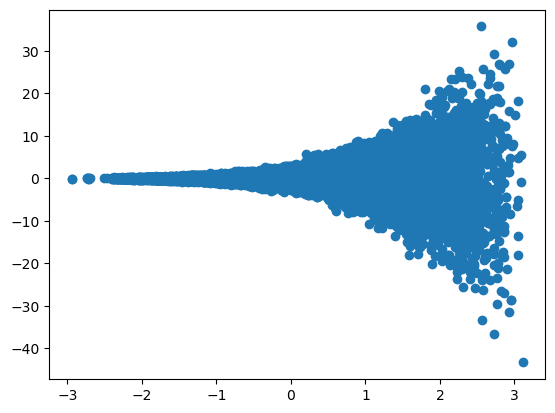

In [30]:
plt.scatter(trace_.posterior.log_sigma, trace_.posterior.x.isel(x_dim=0))

In [ ]:
%%time
trace = nutpie.sample(
    compiled,
    transform_adapt=True,
    chains=2,
    tune=1000,
    draws=1000,
    window_switch_freq=50,
    cores=1,
    seed=123,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,550,0,0.47,15
,0,0,0.00,0


Chain 0: Total available points: 346
loss from diag: -0.112687096
Chain 0: Total available points: 560
loss from diag: 2.4699626
Chain 0: Total available points: 686
loss from diag: 2.0028937
Chain 0: Total available points: 784
loss from diag: 2.6766214
Chain 0: Total available points: 974
loss from diag: 1.9999899
Chain 0: Total available points: 1148
loss from diag: 3.0387752
Chain 0: Total available points: 1250
loss from diag: 3.6671922
Chain 0: Total available points: 1360
loss from diag: 3.5052857
Chain 0: Total available points: 1466
loss from diag: 3.5618715
Chain 0: Total available points: 1568
loss from diag: 3.9110553
Chain 0: Total available points: 2142
loss before optimization:  5.284918
Chain 0: New loss 0.5241283178329468, old loss 4.461075782775879
Chain 0: Total available points: 2780
Chain 0: New loss 0.4064335823059082, old loss 3.4875645637512207
Chain 0: Total available points: 3370
Chain 0: New loss -0.2024444192647934, old loss 4.171247482299805
Chain 0: Total 

In [ ]:
arviz.ess(trace)

In [ ]:
np.log(trace.warmup_sample_stats.step_size).plot.line(x="draw")
plt.ylim(-10, 0)

In [ ]:
trace.warmup_sample_stats.mean_tree_accept.rolling(draw=50).mean().plot.line(x="draw")

In [ ]:
trace.sample_stats.n_steps.sum("draw") + trace.warmup_sample_stats.n_steps.sum("draw")

In [ ]:
arviz.ess(trace.sel(chain=[0, 1])).min()

In [ ]:
arviz.plot_posterior(np.log(trace.posterior.tau))

In [23]:
trace.posterior

<xarray.Dataset> Size: 18MB
Dimensions:        (chain: 1, draw: 463, beta_dim_0: 1536, f_dim_0: 54,
                    lambda_dim_0: 1536, log_lik_dim_0: 54, z_dim_0: 1536)
Coordinates:
  * chain          (chain) int64 8B 0
  * draw           (draw) int64 4kB 0 1 2 3 4 5 6 ... 457 458 459 460 461 462
  * beta_dim_0     (beta_dim_0) int64 12kB 0 1 2 3 4 ... 1532 1533 1534 1535
  * f_dim_0        (f_dim_0) int64 432B 0 1 2 3 4 5 6 7 ... 47 48 49 50 51 52 53
  * lambda_dim_0   (lambda_dim_0) int64 12kB 0 1 2 3 4 ... 1532 1533 1534 1535
  * log_lik_dim_0  (log_lik_dim_0) int64 432B 0 1 2 3 4 5 ... 48 49 50 51 52 53
  * z_dim_0        (z_dim_0) int64 12kB 0 1 2 3 4 5 ... 1531 1532 1533 1534 1535
Data variables:
    beta           (chain, draw, beta_dim_0) float64 6MB 0.0004932 ... -0.000...
    beta0          (chain, draw) float64 4kB 6.816 8.003 6.597 ... 5.446 6.105
    caux           (chain, draw) float64 4kB 0.8977 0.9914 ... 1.105 0.9247
    f              (chain, draw, f_dim_0) float64 200kB -3.708 -2.809 ... 6.037
    lambda         (chain, draw, lambda_dim_0) float64 6MB 0.5658 ... 0.3019
    log_lik        (chain, draw, log_lik_dim_0) float64 200kB -0.02422 ... -0...
    tau            (chain, draw) float64 4kB 0.00215 0.005277 ... 0.00295
    z              (chain, draw, z_dim_0) float64 6MB 0.4054 0.3916 ... -0.1289
Attributes:
    created_at:     2024-10-25T17:49:54.110551+00:00
    arviz_version:  0.19.0.dev0

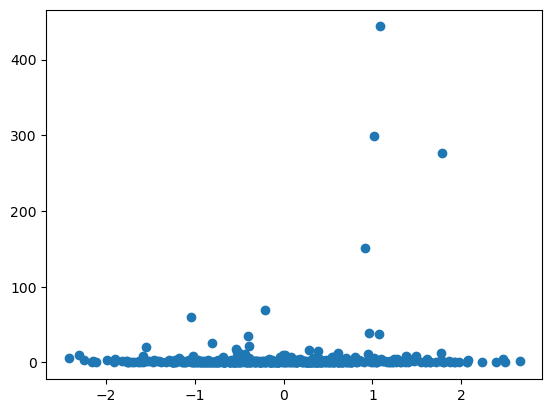

In [34]:
plt.scatter(trace.posterior.z.isel(z_dim_0=0), trace.posterior["lambda"].isel(lambda_dim_0=0))

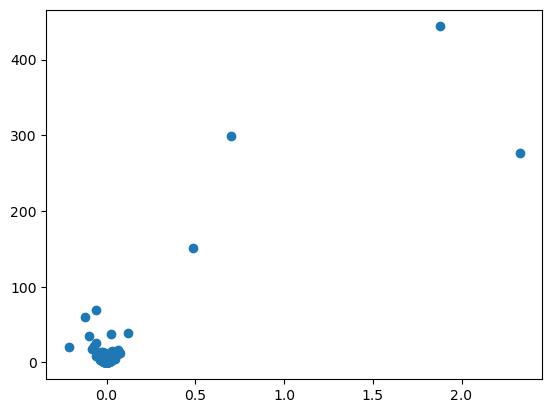

In [33]:
plt.scatter(trace.posterior.beta.isel(beta_dim_0=0), trace.posterior["lambda"].isel(lambda_dim_0=0))

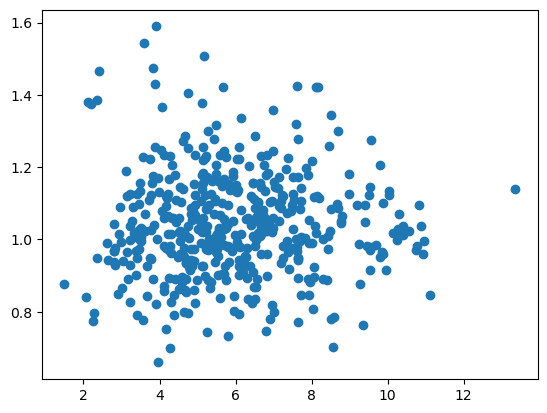

In [26]:
plt.scatter(trace.posterior.beta0, trace.posterior.caux)

In [28]:
arviz.ess(trace_).min()

<xarray.Dataset> Size: 64B
Dimensions:  ()
Data variables:
    beta     float64 8B 16.43
    beta0    float64 8B 391.2
    caux     float64 8B 6.393e+03
    f        float64 8B 20.7
    lambda   float64 8B 13.62
    log_lik  float64 8B 20.7
    tau      float64 8B 340.5
    z        float64 8B 27.92

In [23]:
plt.scatter((trace.posterior.mu_b), (trace.posterior.mu_a))

AttributeError: 'Dataset' object has no attribute 'mu_b'

In [23]:
plt.scatter(np.log(trace.posterior.alpha21), np.log(trace.posterior.alpha12))

AttributeError: 'Dataset' object has no attribute 'alpha21'

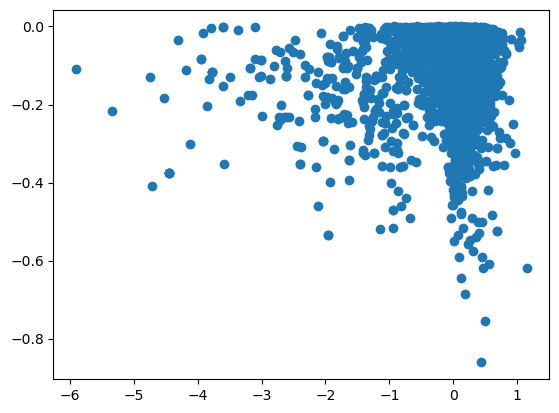

In [39]:
plt.scatter(np.log(trace.posterior.alpha21.values.ravel()), np.log(trace.posterior.gamma.values.ravel()))

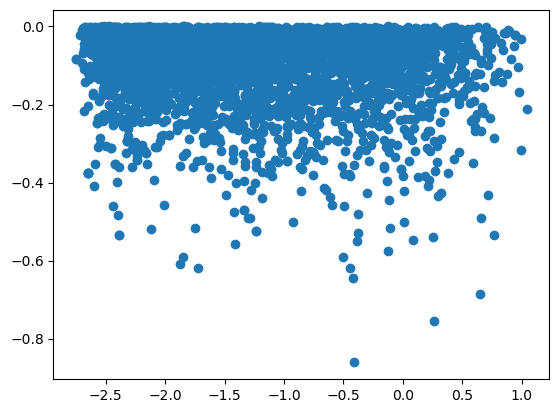

In [35]:
plt.scatter(np.log(trace.posterior.k1.values.ravel()), np.log(trace.posterior.gamma.values.ravel()))

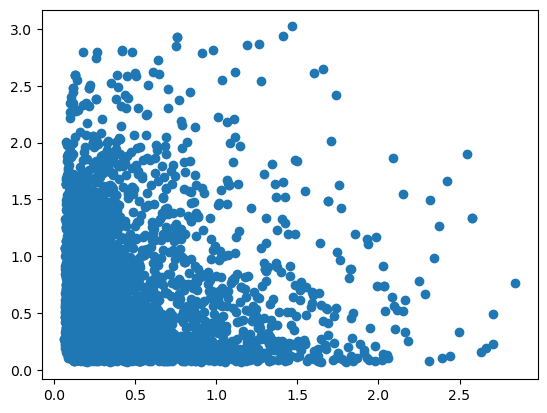

In [51]:
plt.scatter((trace.posterior.k1.values.ravel()), (trace.posterior.k2.values.ravel()))